<a href="https://colab.research.google.com/github/azdfkpot/NNs-and-DEs/blob/main/wave_eq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
The training set is [[1.         1.         0.         0.75       0.25       1.
  0.         0.375      0.625      1.         0.         1.
  0.         1.         0.         0.1875     0.8125     1.
  0.         0.9375     0.0625     1.         0.         0.5625
  0.4375     1.         0.         1.         0.         1.
  0.         0.09375    0.90625    1.         0.         0.84375
  0.15625    1.         0.         0.46875    0.53125    1.
  0.         1.         0.         1.         0.         0.28125
  0.71875    1.         0.5        0.25       0.75       0.125
  0.625      0.375      0.875      0.0625     0.5625     0.3125
  0.8125     0.1875     0.6875     0.4375     0.9375     0.03125
  0.53125    0.28125 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.237739 s

'compile' took 3.325049 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.14e-02, 5.07e-02, 2.10e-02, 5.50e-01, 4.25e-02]    [4.14e-02, 5.07e-02, 2.10e-02, 5.50e-01, 4.25e-02]    []  
1000      [1.41e-03, 1.28e-02, 2.39e-02, 8.63e-03, 4.06e-04]    [1.41e-03, 1.28e-02, 2.39e-02, 8.63e-03, 4.06e-04]    []  
2000      [6.61e-04, 1.41e-02, 1.55e-02, 4.35e-03, 3.00e-04]    [6.61e-04, 1.41e-02, 1.55e-02, 4.35e-03, 3.00e-04]    []  
3000      [4.29e-03, 1.43e-02, 1.26e-02, 3.52e-03, 3.65e-03]    [4.29e-03, 1.43e-02, 1.26e-02, 3.52e-03, 3.65e-03]    []  
4000      [4.51e-04, 1.31e-02, 1.10e-02, 3.01e-03, 6.18e-05]    [4.51e-04, 1.31e-02, 1.10e-02, 3.01e-03, 6.18e-05]    []  
5000      [5.58e-04, 1.10e-02, 1.06e-02, 2.38e-03, 3.77e-05]    [5.58e-04, 1.10e-02, 1.06e-02, 2.38e-03, 3.77e-05]    []  
6000      [4.53e-02, 9.23e-03, 1.06e-02, 1.84e-03, 4.46e-03] 

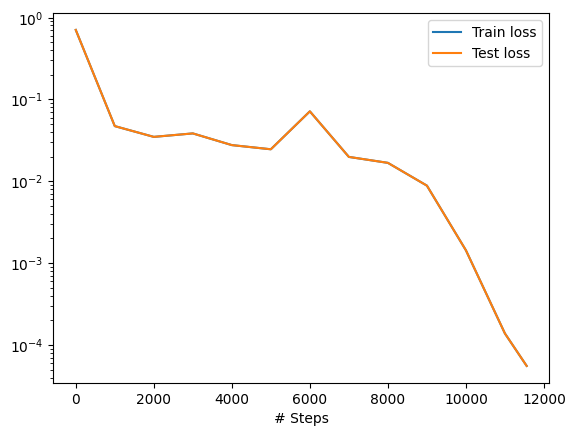

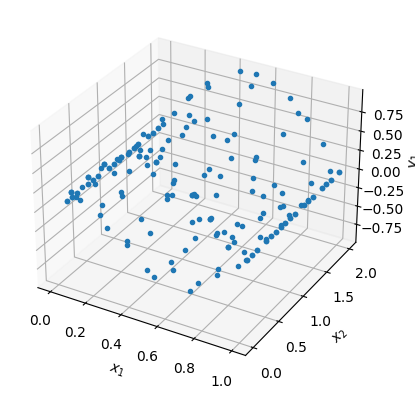

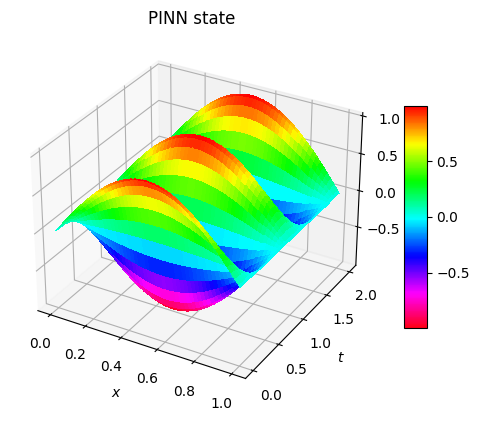

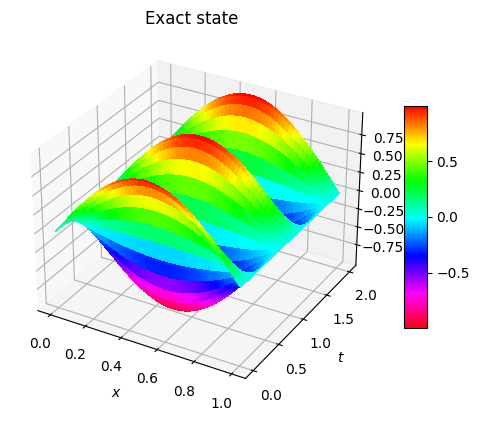

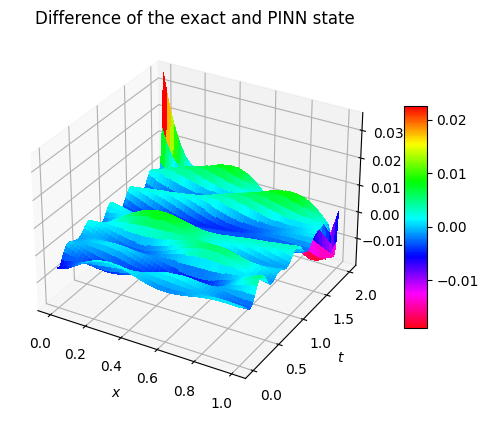

Text(0.5, 1.0, 'Training set')

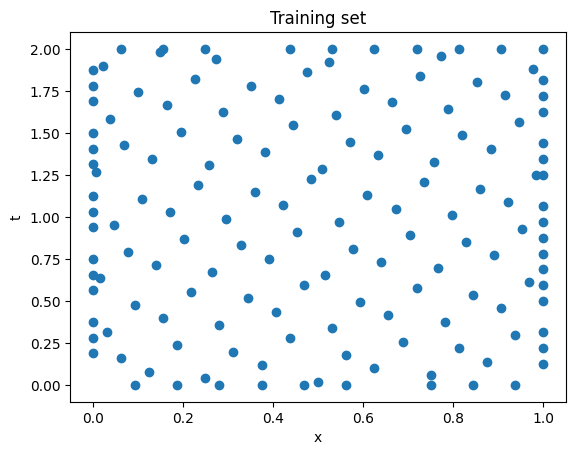

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from itertools import product
import deepxde as dde
import math
import pathlib
import os



OUTPUT_DIRECTORY = pathlib.Path.cwd() / "results" / "wave_equation"
if not OUTPUT_DIRECTORY.exists():
    os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)


def pde(x, y):  # wave equation
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)

    return dy_tt - 4*dy_xx


def initial_pos(x):  # initial position

    return np.sin(np.pi * x[:, 0:1])


def initial_velo(x):  # initial velocity

    return 0.0


def boundary_left(x, on_boundary):  # boundary x=0
    is_on_boundary_left = on_boundary and np.isclose(x[0], 0)

    return is_on_boundary_left

def boundary_right(x, on_boundary):  # boundary x=1
    is_on_boundary_right = on_boundary and np.isclose(x[0], 1)

    return is_on_boundary_right

def boundary_bottom(x, on_boundary):  # boundary t=0
    is_on_boundary_bottom = (
        on_boundary
        and np.isclose(x[1], 0)
        and not np.isclose(x[0], 0)
        and not np.isclose(x[0], 1)
    )

    return is_on_boundary_bottom


def boundary_upper(x, on_boundary):  # boundary t=2
    is_on_boundary_upper = (
        on_boundary
        and np.isclose(x[1], 2)
        and not np.isclose(x[0], 0)
        and not np.isclose(x[0], 1)
    )

    return is_on_boundary_upper

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.cos(2*np.pi*x[:, 1:])

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 2])


bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left)  #correct

bc2 = dde.DirichletBC(geom, lambda x: 0, boundary_right) #correct

bc3 = dde.DirichletBC(geom, initial_pos, boundary_bottom)  #correct

bc4 = dde.NeumannBC(geom, initial_velo, boundary_bottom)  #correct




data = dde.data.TimePDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=100,
    num_boundary=50, solution=func
)
print("The training set is {}".format(data.train_x_all.T))
net = dde.maps.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")  #the input layer has size 2, there are 4 hidden layers of size 50 and one output layer of size 1

#Activation function is tanh; the weights are initially chosen to be uniformly distributed according to Glorat distribution


model = dde.Model(data, net)

model.compile("adam", lr=0.001)

model.train(epochs=8000)

model.compile("L-BFGS-B")

losshistory, train_state = model.train()

dde.saveplot(
    losshistory, train_state, issave=True, isplot=True, output_dir=OUTPUT_DIRECTORY
)



#Post-processing: error analysis and figures

xx=np.linspace(0,1,100)
tt=np.linspace(0,2,200)

list_all_data=list(product(*[list(xx), list(tt)], repeat=1))


training_set=[(data.train_x_all.T[0][k], data.train_x_all.T[1][k]) for k in range(len(data.train_x_all.T[0]))]


def exact_function(x):
    return math.sin(math.pi*x[0])*math.cos(2*math.pi*x[1])



X = np.linspace(0, 1, 100)
t = np.linspace(0, 2, 200)

X_repeated = np.repeat(X, t.shape[0])
t_tiled = np.tile(t, X.shape[0])
XX = np.vstack((X_repeated, t_tiled)).T

state_predict = model.predict(XX).T
state_predict_M = state_predict.reshape((100, 200)).T

Xx, Tt = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 200))

fig = plt.figure()  # plot of predicted state
ax = plt.axes(projection="3d")
surf = ax.plot_surface(
    Xx, Tt, state_predict_M, cmap="hsv_r", linewidth=0, antialiased=False
)

ax.set_title("PINN state ")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.colorbar(surf, shrink=0.6, aspect=10)

plt.show()


def explicit_state(x,t):
    return np.sin(math.pi*x)*np.cos(2*math.pi*t)


state_exact = explicit_state(Xx, Tt)  # computation of exact state

fig = plt.figure()  # plot of exact state
ax = plt.axes(projection="3d")
surf2 = ax.plot_surface(
    Xx, Tt, state_exact, cmap="hsv_r", linewidth=0, antialiased=False
)

ax.set_title("Exact state ")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()



fig = plt.figure()  # plot of the difference between exact and PINN state
ax = plt.axes(projection="3d")
surf2 = ax.plot_surface(
    Xx, Tt, state_exact-state_predict_M, cmap="hsv_r",
    linewidth=0, antialiased=False
)

ax.set_title("Difference of the exact and PINN state")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()


#Plot the training set and validation set
fig = plt.figure()

plt.plot(data.train_x_all.T[0], data.train_x_all.T[1],"o")
#plt.plot(validating_set.T[0], validating_set.T[1], "r", label="Validation set")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Training set")
#plt.legend()




In [ ]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.9 MB/s eta 0:00:00
